# Reconstructing Temperature Response Functions
Look at how selecting certain elements/ions impacts predictions of the intensity as compared to the actual temperature response functions.

In [4]:
import urllib
import io

import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import seaborn
import astropy.units as u
import plasmapy
import fiasco
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import Element,Ion,EmissionModel,list_elements

%matplotlib inline

In [5]:
temperature = 10.**(np.arange(5,8.1,0.1))*u.K
density = np.logspace(15-np.log10(temperature.value.max()),15-np.log10(temperature.value.min()),5)/(u.cm**3)

In [6]:
ions = [Element(el,temperature=temperature,ion_kwargs={'abundance_filename':'sun_coronal_1992_feldman'})
        for el in list_elements()]

In [4]:
em_model = EmissionModel(density,*ions)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/fiasco-0.1.dev104-py3.6.egg/fiasco/ion.py:75: UserWarning: No B abundance available for dataset sun_coronal_1992_feldman
  .format(self.atomic_symbol, self._dset_names['abundance_filename']))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/fiasco-0.1.dev104-py3.6.egg/fiasco/ion.py:75: UserWarning: No Be abundance available for dataset sun_coronal_1992_feldman
  .format(self.atomic_symbol, self._dset_names['abundance_filename']))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/fiasco-0.1.dev104-py3.6.egg/fiasco/ion.py:75: UserWarning: No Cl abundance available for dataset sun_coronal_1992_feldman
  .format(self.atomic_symbol, self._dset_names['abundance_filename']))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/fiasco-0.1.dev104-py3.6.egg/fiasco/ion.py:75: UserWarning: No Co abundance available for dataset sun_coronal_1992_feldman
  .format(se

In [5]:
#em_model.calculate_emissivity('/Users/willbarnes/Desktop/emiss_table.h5',notebook=True)
em_model.emissivity_savefile = '/Users/willbarnes/Desktop/emiss_table.h5'

In [6]:
aia = InstrumentSDOAIA([0,1]*u.s)

In [33]:
list_elements()

['Al',
 'Ar',
 'B',
 'Be',
 'C',
 'Ca',
 'Cl',
 'Co',
 'Cr',
 'Cu',
 'F',
 'Fe',
 'H',
 'He',
 'K',
 'Li',
 'Mg',
 'Mn',
 'N',
 'Na',
 'Ne',
 'Ni',
 'O',
 'P',
 'S',
 'Sc',
 'Si',
 'Ti',
 'V',
 'Zn']

In [41]:
accepted_ions = [
    'iron',
    'calcium',
    'magnesium',
    'oxygen',
    'silicon',
    'sulfur',
    'nickel'
]
#accepted_ions = [plasmapy.atomic.element_name(s) for s in list_elements()]

In [42]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em_model.temperature.shape+em_model.density.shape)
    components = {}
    for ion in em_model:
        if ion.element_name not in accepted_ions:
            continue
        wvl,emiss = em_model.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = scipy.interpolate.splev(wvl.value,channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value,response)
        ab = ion.abundance.value
        tmp *= ab*ion.ioneq.value[:,np.newaxis]/em_model.density.value/4./np.pi
        counts += tmp
        if ion.element_name in components:
            components[ion.element_name] += tmp
        else:
            components[ion.element_name] = tmp
    calc_temp_response[channel['name']] = counts
    calc_temp_response[f'{channel["name"]}_components'] = components

In [43]:
const_p_indices = np.array([(i,np.argmin(np.fabs(em_model.density.value-d.value))) 
                            for i,d in enumerate(1e15/em_model.temperature)])

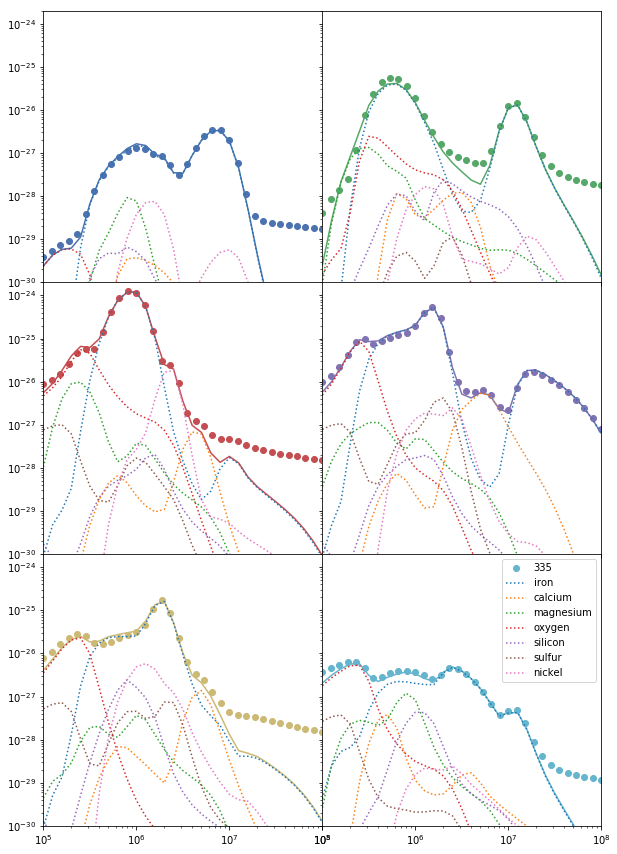

In [96]:
fig,axes = plt.subplots(3,2,figsize=(10,15),sharex=True,sharey=True)
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = scipy.interpolate.splev(data_temperature,channel['temperature_response_spline'])
    ax.plot(data_temperature,real_response,
            'o',markevery=3,color=seaborn.color_palette('deep')[i],label=channel['name'])
    ax.plot(em_model.temperature,calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
             color=seaborn.color_palette('deep')[i],ls='-')
    for j,element in enumerate(accepted_ions):
        if element in calc_temp_response[f'{channel["name"]}_components']:
            ax.plot(em_model.temperature,
                    calc_temp_response[f'{channel["name"]}_components'][element][const_p_indices[:,0],const_p_indices[:,1]],
                    color=f'C{j%10}',ls=':',label=element)
    #ax.axvline(x=1e6,ls='--',color='k')
    #ax.axvline(x=1e7,ls='--',color='k')
    if i==5:
        ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,2e-24])
plt.xlim([1e5,1e8])
#plt.legend()
plt.subplots_adjust(wspace=0.,hspace=0.)

In [36]:
chan=211
max_comps = [(k,np.max(calc_temp_response[f'{chan}_components'][k]/calc_temp_response[f'{chan}_components']['iron'])) 
             for k in calc_temp_response[f'{chan}_components']]

In [91]:
sorted(max_comps,key=lambda x: x[1], reverse=True)

[('oxygen', 4353.1520788053685),
 ('nitrogen', 1556.1865996881413),
 ('sulfur', 649.51984821472433),
 ('carbon', 117.81259935149498),
 ('helium', 101.29077082048018),
 ('neon', 58.644324280737557),
 ('argon', 15.666628489582433),
 ('sodium', 13.427495668868016),
 ('magnesium', 5.1200118694800878),
 ('calcium', 2.7109507757316802),
 ('silicon', 1.5897861116217682),
 ('iron', 1.0),
 ('manganese', 0.39603239069123986),
 ('nickel', 0.22041280937436378),
 ('chromium', 0.15857817097815838),
 ('potassium', 0.04982451239989074),
 ('aluminium', 0.023223053978275371),
 ('chlorine', 0.011796111448452832),
 ('zinc', 0.010951369839642771),
 ('phosphorus', 0.0012131573195769527),
 ('cobalt', 0.00038425362038503467),
 ('titanium', 0.00033309262361616202),
 ('hydrogen', 0.0)]

In [ ]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt')
                     .readlines())
col_names = [str(t.strip()).split('  ')[-1] for t in tmp[8:15]]
col_names = [c[:-1] for c in col_names[0:2]] + ['Element','Ion','Wavelength'] + [c[:-1] for c in col_names[3:]]
table_io = io.StringIO(','.join(col_names) + '\n' 
                       + '\n'.join([','.join(filter(None,t.strip().decode('utf8').split(' '))) for t in tmp[19:]]))
df = pandas.read_csv(table_io)

In [ ]:
df[df['Active region'] == 2]